<a href="https://colab.research.google.com/github/rohinishimpatwar/The-NLP-News-Sentiment-Trading-Strategy/blob/master/Factor%20Model/Part4_Factor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import bs4 as bs
import datetime as dt
import os
import pandas_datareader.data as web
import pickle
import requests
import re
import pandas as pd

os.chdir = ('C:/Users/Anastasia/Desktop/New folder/Разное/Учеба/DS4A')

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = ticker[:-1]
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    tickers.remove('BRK.B')
    tickers.remove('BF.B')
    tickers.remove('CTVA')
    tickers.remove('DOW')
    tickers.remove('FOXA')
    tickers.remove('FOX')
    tickers.remove('NLOK')
    tickers.remove('LHX')
    tickers.remove('VIAC')
    
    return tickers


# save_sp500_tickers()
def get_data_from_yahoo(reload_sp500=True):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2018, 1, 1)
    end = dt.datetime(2018, 5, 31)
    df = pd.DataFrame()
    
    for ticker in tickers:
        print(ticker)
        ind_df = web.DataReader(ticker, 'yahoo', start, end)
        ind_df.reset_index(inplace=True)
        #ind_df.set_index("Date", inplace=True)
        ind_df['Return'] = ind_df['Close'] / ind_df['Close'].shift(1) - 1
        ind_df['Symbol'] = ticker
        
        df = df.append(ind_df)
        print(df)
        
    df.to_csv('sp500returns.csv')

get_data_from_yahoo()

In [0]:
import numpy as np
ret = pd.read_csv('sp500returns.csv').iloc[:,1:]

sent_vader = pd.read_csv('scored_news_vader.csv').iloc[:,1:]

# Constructing industry sentiment index:
dates = np.sort(sent_vader.dropna().published.unique())[9:]
ind_names = sent_vader['industry_0'].unique()
sent_ind_vader = pd.DataFrame(index=dates,columns=ind_names)

for ind in ind_names:
    for t in dates:
        sent_ind_vader.loc[t,ind] = sent_vader[sent_vader.published == t][sent_vader.industry_0 == ind].compound.mean()
        
sent_ind_vader = sent_ind_vader.fillna(0)    
sent_ind_vader

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


,Consumer Staples,Financials,Information Technology,Consumer Discretionary,Communication Services,Industrials,Health Care,Energy,Utilities,Real Estate,Materials
2018-01-02,0.682044,0.542936,0.693776,0.658557,0.675063,0.470732,0.365956,0.903367,0.882633,0.440400,0.986500
2018-01-03,0.683464,0.499979,0.349526,0.477347,0.303200,0.411246,0.716713,0.585600,0.371124,0.764263,0.735386
2018-01-04,0.253458,0.363355,0.190558,0.051105,0.430456,0.432015,0.767028,0.458888,0.475342,0.919300,0.392225
2018-01-05,0.753763,0.345057,0.274156,0.441240,0.517407,0.567838,0.854115,0.005680,0.215023,0.689300,0.953267
2018-01-06,0.000000,0.636192,0.073525,0.446371,0.510600,-0.630500,-0.125600,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2018-05-27,0.859100,0.955150,0.986700,0.240800,0.000000,0.827100,0.986800,-0.725829,0.000000,0.000000,0.000000
2018-05-28,0.847500,0.084154,0.752800,-0.289225,0.409975,0.309767,0.409600,-0.014650,-0.872000,0.987000,0.000000
2018-05-29,0.072544,0.011626,0.751771,0.389320,0.389889,0.971725,0.188941,-0.121641,0.798780,0.000000,0.992688
2018-05-30,0.493900,0.180068,0.844293,0.459890,0.386775,-0.080625,0.197062,-0.366923,0.983200,0.006350,0.912133


In [0]:
news = pd.read_csv('allnews_with_all_labels.csv')
bert_sent = pd.read_csv('bert_predicted_result_40k.csv')
bert_sent = bert_sent.sort_values('index')
news['bert_sent'] = bert_sent['label']
news = news[['Unnamed: 0', 'published', 'company_0', 'industry_0', 'bert_sent']]
news['published'] = sent_vader['published']

# Constructing industry sentiment index:
ind_names = news['industry_0'].unique()
sent_ind_bert = pd.DataFrame(index=dates,columns=ind_names)

for ind in ind_names:
    for t in dates:
        sent_ind_bert.loc[t,ind] = news[news.published == t][news.industry_0 == ind].bert_sent.mean()
        
sent_ind_bert = sent_ind_bert.fillna(0)    
sent_ind_bert
#type(sent_vader['published'])

C:\Users\Anastasia\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,2

,Industrials,Consumer Staples,Communication Services,Financials,Consumer Discretionary,Health Care,Information Technology,Energy,Utilities,Materials,Real Estate
2018-01-02,0.133333,0.200000,-0.384615,-0.108108,-0.200000,-0.166667,0.090909,0.000000,0.200000,0.000000,-1.000000
2018-01-03,-0.071429,0.166667,-0.083333,-0.045045,-0.333333,-0.352941,0.185185,-0.125000,0.000000,0.000000,0.666667
2018-01-04,-0.090909,-0.250000,-0.176471,-0.191011,-0.333333,-0.117647,-0.058824,-0.400000,-0.800000,-0.428571,0.333333
2018-01-05,0.055556,0.187500,0.181818,-0.110000,-0.304348,-0.250000,-0.125000,0.230769,0.000000,-1.000000,-1.000000
2018-01-06,0.000000,-1.000000,0.000000,-0.250000,0.333333,0.400000,1.000000,-0.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2018-05-27,-0.333333,0.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000
2018-05-28,-0.285714,-0.500000,-0.400000,-0.147059,-0.300000,0.333333,-0.200000,-0.800000,0.000000,0.000000,1.000000
2018-05-29,-0.285714,-0.238095,-0.166667,-0.169811,-0.323529,-0.344828,0.074074,-0.166667,-0.333333,-0.333333,-0.200000
2018-05-30,0.000000,-0.357143,-0.190476,-0.112903,-0.265306,-0.071429,-0.111111,-0.071429,-0.333333,0.500000,-0.250000


In [0]:
get_industries = pd.read_csv('sp500companies_industry.csv')[['Symbol','Security','GICS Sector']]
get_industries
ret = pd.merge(ret, get_industries, on='Symbol')
#ret = pd.merge(ret, on='company_0' )
ret['Industry Sentiment vader'] = 0
ret['Industry Sentiment bert'] = 0
get_industries

,Symbol,Security,GICS Sector
0,MMM,3M Company,Industrials
1,ABT,Abbott Laboratories,Health Care
2,ABBV,AbbVie Inc.,Health Care
3,ABMD,ABIOMED Inc,Health Care
4,ACN,Accenture plc,Information Technology
...,...,...,...
500,YUM,Yum! Brands Inc,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet Holdings,Health Care
503,ZION,Zions Bancorp,Financials


In [0]:
# Adding Industry Sentiment column to returns data
ind_sent = []
for i in range(51527):
    t = str(ret['Date'][i])
    ind = str(ret['GICS Sector'][i])
    ind_sent.append(sent_ind_vader.loc[t,ind])
    
    
ret['Industry Sentiment vader'] = ind_sent  

ind_sent = []
for i in range(51527):
    t = str(ret['Date'][i])
    ind = str(ret['GICS Sector'][i])
    ind_sent.append(sent_ind_bert.loc[t,ind])
    
    
ret['Industry Sentiment bert'] = ind_sent 
ret

,Date,High,Low,Open,Close,Volume,Adj Close,Return,Symbol,Security,GICS Sector,Industry Sentiment vader,Industry Sentiment bert
0,2018-01-02,237.070007,232.809998,235.779999,235.639999,2931000.0,220.075348,NaN,MMM,3M Company,Industrials,0.470732,0.133333
1,2018-01-03,235.729996,233.289993,235.070007,235.630005,2193700.0,220.065979,-0.000042,MMM,3M Company,Industrials,0.411246,-0.071429
2,2018-01-04,239.440002,236.470001,237.000000,238.710007,2243100.0,222.942566,0.013071,MMM,3M Company,Industrials,0.432015,-0.090909
3,2018-01-05,240.899994,237.740005,238.649994,240.570007,1835900.0,224.679718,0.007792,MMM,3M Company,Industrials,0.567838,0.055556
4,2018-01-08,240.940002,239.179993,239.380005,239.789993,1869000.0,223.951233,-0.003242,MMM,3M Company,Industrials,0.822281,-0.086957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51522,2018-05-24,85.559998,84.169998,85.099998,84.750000,1244900.0,83.853821,-0.001532,ZTS,Zoetis,Health Care,0.064761,-0.166667
51523,2018-05-25,85.050003,83.550003,84.870003,83.669998,1964000.0,82.785233,-0.012743,ZTS,Zoetis,Health Care,0.183978,0.133333
51524,2018-05-29,83.419998,82.400002,82.980003,83.150002,1822100.0,82.270737,-0.006215,ZTS,Zoetis,Health Care,0.188941,-0.344828
51525,2018-05-30,85.290001,83.790001,83.790001,84.449997,1893200.0,83.556976,0.015634,ZTS,Zoetis,Health Care,0.197062,-0.071429


In [0]:
# Constructing Company-specific Sentiment Bert:

comp_names = news['company_0'].unique()
sent_comp_bert = pd.DataFrame(index=dates,columns=comp_names)

for com in comp_names:
    for t in dates:
        sent_comp_bert.loc[t,com] = news[news.published == t][news.company_0 == com].bert_sent.mean()
        
sent_comp_bert = sent_comp_bert.fillna(0)    
sent_comp_bert

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,General Electric,Walmart,AT&T,Southwest Airlines,BlackRock,E*Trade,Dollar Tree,Philip Morris International,Berkshire Hathaway,Anthem,...,Expeditors,AutoZone Inc,CF Industries Holdings Inc,Mid-America Apartments,Macy's Inc.,QUALCOMM Inc.,Williams Cos.,ABIOMED Inc,Evergy,Kohl's Corp.
2018-01-02,0.166667,0.000000,-0.444444,0.0,0.000000,-0.175000,0.0,0.0,-0.833333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,-0.750000,0.400000,-0.285714,1.0,0.333333,-0.079365,0.0,0.0,-0.142857,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,-1.000000,0.000000,0.000000,-1.0,0.333333,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,-0.200000,-0.333333,0.200000,-1.0,-1.000000,-0.083333,0.0,-1.0,-0.200000,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-06,0.000000,0.000000,0.000000,0.0,0.000000,-0.500000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-27,0.000000,0.000000,0.000000,0.0,-1.000000,0.200000,0.0,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-28,-0.333333,-1.000000,-0.250000,-1.0,0.000000,-0.352941,0.0,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-29,-0.400000,-0.500000,0.000000,0.0,0.000000,-0.200000,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-30,0.000000,-0.666667,-0.285714,0.0,0.666667,-0.146667,0.0,1.0,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Adding Company Sentiment column to returns data
comp_sent = []
for i in range(51527):
    t = str(ret['Date'][i])
    comp = str(ret['Security'][i])
    if((comp in sent_comp_bert.columns) & (t!='2018-01-02')):
        comp_sent.append(sent_comp_bert.loc[t,comp])
    else:
        comp_sent.append(0)
    
    
ret['Company Sentiment'] = comp_sent    
ret.to_csv('returns_with_sentiment.csv')

In [0]:
ret

,Date,High,Low,Open,Close,Volume,Adj Close,Return,Symbol,Security,GICS Sector,Industry Sentiment vader,Industry Sentiment bert,Company Sentiment
0,2018-01-02,237.070007,232.809998,235.779999,235.639999,2931000.0,220.075348,NaN,MMM,3M Company,Industrials,0.470732,0.133333,0.0
1,2018-01-03,235.729996,233.289993,235.070007,235.630005,2193700.0,220.065979,-0.000042,MMM,3M Company,Industrials,0.411246,-0.071429,0.0
2,2018-01-04,239.440002,236.470001,237.000000,238.710007,2243100.0,222.942566,0.013071,MMM,3M Company,Industrials,0.432015,-0.090909,0.0
3,2018-01-05,240.899994,237.740005,238.649994,240.570007,1835900.0,224.679718,0.007792,MMM,3M Company,Industrials,0.567838,0.055556,0.0
4,2018-01-08,240.940002,239.179993,239.380005,239.789993,1869000.0,223.951233,-0.003242,MMM,3M Company,Industrials,0.822281,-0.086957,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51522,2018-05-24,85.559998,84.169998,85.099998,84.750000,1244900.0,83.853821,-0.001532,ZTS,Zoetis,Health Care,0.064761,-0.166667,0.0
51523,2018-05-25,85.050003,83.550003,84.870003,83.669998,1964000.0,82.785233,-0.012743,ZTS,Zoetis,Health Care,0.183978,0.133333,0.0
51524,2018-05-29,83.419998,82.400002,82.980003,83.150002,1822100.0,82.270737,-0.006215,ZTS,Zoetis,Health Care,0.188941,-0.344828,1.0
51525,2018-05-30,85.290001,83.790001,83.790001,84.449997,1893200.0,83.556976,0.015634,ZTS,Zoetis,Health Care,0.197062,-0.071429,-1.0


In [0]:
import numpy as np
ret['LOGCAP'] = np.log(np.multiply(ret['Close'],ret['Volume']))
ret['Date'] = pd.to_datetime(ret['Date'],format='%Y-%m-%d')
ret

C:\Users\Anastasia\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,High,Low,Open,Close,Volume,Adj Close,Return,Symbol,Security,GICS Sector,Industry Sentiment vader,Industry Sentiment bert,Company Sentiment,LOGCAP
0,2018-01-02,237.070007,232.809998,235.779999,235.639999,2931000.0,220.075348,NaN,MMM,3M Company,Industrials,0.470732,0.133333,0.0,20.353159
1,2018-01-03,235.729996,233.289993,235.070007,235.630005,2193700.0,220.065979,-0.000042,MMM,3M Company,Industrials,0.411246,-0.071429,0.0,20.063363
2,2018-01-04,239.440002,236.470001,237.000000,238.710007,2243100.0,222.942566,0.013071,MMM,3M Company,Industrials,0.432015,-0.090909,0.0,20.098619
3,2018-01-05,240.899994,237.740005,238.649994,240.570007,1835900.0,224.679718,0.007792,MMM,3M Company,Industrials,0.567838,0.055556,0.0,19.906057
4,2018-01-08,240.940002,239.179993,239.380005,239.789993,1869000.0,223.951233,-0.003242,MMM,3M Company,Industrials,0.822281,-0.086957,0.0,19.920678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51522,2018-05-24,85.559998,84.169998,85.099998,84.750000,1244900.0,83.853821,-0.001532,ZTS,Zoetis,Health Care,0.064761,-0.166667,0.0,18.474272
51523,2018-05-25,85.050003,83.550003,84.870003,83.669998,1964000.0,82.785233,-0.012743,ZTS,Zoetis,Health Care,0.183978,0.133333,0.0,18.917374
51524,2018-05-29,83.419998,82.400002,82.980003,83.150002,1822100.0,82.270737,-0.006215,ZTS,Zoetis,Health Care,0.188941,-0.344828,1.0,18.836146
51525,2018-05-30,85.290001,83.790001,83.790001,84.449997,1893200.0,83.556976,0.015634,ZTS,Zoetis,Health Care,0.197062,-0.071429,-1.0,18.889939


In [0]:
groups = ret.groupby(['Date'])

m = pd.DataFrame()
portfolios = {}
ret_mean = {}
cap_mean = {}
ret_mean_next = {}
cap_mean_next = {}

pnum = 10
print('No portfolios!')
for idx in range(pnum) :
    portfolios[idx] = pd.DataFrame()

for group_name, group in groups :
    g = group.dropna().sort_values(['Company Sentiment'])
    l = int(g.shape[0]/pnum)
    for idx in range(pnum) :
        portfolios[idx] = portfolios[idx].append(g.iloc[idx*l : (idx+1)*l - 1])

No portfolios!


In [0]:
for idx in range(pnum) :
    ret_mean[idx] = portfolios[idx].groupby('Date')['Return'].mean()
    #cap_mean[idx] = portfolios[idx].groupby('Date')['LOGCAP'].mean()
ret_mean

{0: Date
 2018-01-03    0.006900
 2018-01-04    0.003015
 2018-01-05    0.006842
 2018-01-08    0.001131
 2018-01-09    0.001205
                 ...   
 2018-05-24   -0.002253
 2018-05-25   -0.004442
 2018-05-29   -0.010371
 2018-05-30    0.014167
 2018-05-31   -0.009446
 Name: Return, Length: 103, dtype: float64,
 1: Date
 2018-01-03    0.004525
 2018-01-04    0.005997
 2018-01-05    0.004500
 2018-01-08    0.003665
 2018-01-09   -0.001820
                 ...   
 2018-05-24   -0.000277
 2018-05-25    0.000607
 2018-05-29   -0.013244
 2018-05-30    0.013108
 2018-05-31   -0.006772
 Name: Return, Length: 103, dtype: float64,
 2: Date
 2018-01-03    0.006887
 2018-01-04    0.003311
 2018-01-05    0.005762
 2018-01-08    0.004485
 2018-01-09    0.001939
                 ...   
 2018-05-24    0.003249
 2018-05-25   -0.002989
 2018-05-29   -0.009379
 2018-05-30    0.014090
 2018-05-31   -0.011283
 Name: Return, Length: 103, dtype: float64,
 3: Date
 2018-01-03    0.004970
 2018-01-04    0

In [0]:
ff_fact = pd.read_csv('f-f_factors.csv', sep = '\t', decimal=',')
ff_fact.iloc[:,0] = ff_fact.iloc[:,0].astype(str)
ff_fact.iloc[:,0] = pd.to_datetime(ff_fact.iloc[:,0],format='%Y-%m-%d')
ff_fact['Mkt-RF'] = pd.to_numeric(ff_fact['Mkt-RF'],errors='coerce')
ff_fact['SMB'] = pd.to_numeric(ff_fact['SMB'],errors='coerce')
ff_fact['HML'] = pd.to_numeric(ff_fact['HML'],errors='coerce')
ff_fact['RF'] = pd.to_numeric(ff_fact['RF'],errors='coerce')
ff_fact.iloc[:,1:] = ff_fact.iloc[:,1:]/100
ff_fact

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,2018-01-02,0.0085,0.0036,-0.0022,0.05
1,2018-01-03,0.0059,-0.0039,-0.0021,0.05
2,2018-01-04,0.0042,-0.0026,0.0024,0.05
3,2018-01-05,0.0066,-0.0034,-0.0027,0.05
4,2018-01-08,0.0019,-0.0016,0.0007,0.05
...,...,...,...,...,...
99,2018-05-24,-0.0016,0.0034,-0.0031,0.06
100,2018-05-25,-0.0021,0.0022,-0.0040,0.06
101,2018-05-29,-0.0103,0.0132,-0.0103,0.06
102,2018-05-30,0.0131,0.0007,0.0035,0.06


In [0]:
import statsmodels.api as sm
dates = np.sort(ret.dropna().Date.unique())
cpm = {}
mkt = ff_fact['Mkt-RF'][1:]
X = sm.add_constant(mkt)
for idx in range(pnum) :
    ret_mean_next[idx] = np.empty(len(dates))
    cap_mean_next[idx] = np.empty(len(dates))
    for i in range(len(dates) - 1):
        date = dates[i]
        ndate = dates[i+1]
        permno = portfolios[idx].Symbol[portfolios[idx].Date == date]
        p = ret[ret.Date == ndate]
        p = p[p.Symbol.isin(permno)]
        ret_mean_next[idx][i] = p.Return.mean() - ff_fact.iloc[i, 4]
        cap_mean_next[idx][i] = p.LOGCAP.mean()
    cpm[idx] = sm.OLS(ret_mean_next[idx], X).fit()

In [0]:
np.set_printoptions(precision=4)
print('\tRET\talpha\tbeta')
for idx in range(pnum) :
    print("{:d}\t{:.4f}\t{:.4f}\t{:.4f}".format(idx,
        ret_mean_next[idx].mean(), 
        cpm[idx].params[0], cpm[idx].params[1]))

	RET	alpha	beta
0	-0.0494	-0.0493	-0.6353
1	-0.0492	-0.0490	-0.6641
2	-0.0500	-0.0498	-0.6641
3	-0.0492	-0.0491	-0.6475
4	-0.0497	-0.0496	-0.6437
5	-0.0499	-0.0498	-0.6308
6	-0.0497	-0.0496	-0.6387
7	-0.0495	-0.0494	-0.6166
8	-0.0500	-0.0499	-0.6413
9	-0.0497	-0.0496	-0.6137


In [0]:
long_short_ret = portfolios[9].groupby('Date')['Return'].mean() - portfolios[0].groupby('Date')['Return'].mean()
long_ret = portfolios[9].groupby('Date')['Return'].mean()
short_ret = -portfolios[0].groupby('Date')['Return'].mean()
long_short = pd.DataFrame(long_short_ret)
strat_sum = pd.DataFrame()
strat_sum['LS ret'] = long_short_ret
strat_sum['Long ret'] = long_ret
strat_sum['Short ret'] = short_ret
strat_sum['MktRF'] = np.array(mkt)
strat_sum['Date'] = np.sort(ret.dropna().Date.unique())
strat_sum['Mkt_cum_ret'] = (1+strat_sum['MktRF']).cumprod() - 1
strat_sum['LS_cum_ret'] = (1+strat_sum['LS ret']).cumprod() - 1
strat_sum['L_cum_ret'] = (1+strat_sum['Long ret']).cumprod() - 1
strat_sum['S_cum_ret'] = (1+strat_sum['Short ret']).cumprod() - 1
print(strat_sum)

              LS ret  Long ret  Short ret   MktRF       Date  Mkt_cum_ret  \
Date                                                                        
2018-01-03 -0.002734  0.004166  -0.006900  0.0059 2018-01-03     0.005900   
2018-01-04 -0.000667  0.002348  -0.003015  0.0042 2018-01-04     0.010125   
2018-01-05 -0.003992  0.002850  -0.006842  0.0066 2018-01-05     0.016792   
2018-01-08  0.004120  0.005251  -0.001131  0.0019 2018-01-08     0.018724   
2018-01-09  0.001420  0.002625  -0.001205  0.0015 2018-01-09     0.020252   
...              ...       ...        ...     ...        ...          ...   
2018-05-24  0.002513  0.000260   0.002253 -0.0016 2018-05-24     0.020336   
2018-05-25  0.002104 -0.002338   0.004442 -0.0021 2018-05-25     0.018193   
2018-05-29  0.001577 -0.008794   0.010371 -0.0103 2018-05-29     0.007706   
2018-05-30  0.000882  0.015049  -0.014167  0.0131 2018-05-30     0.020907   
2018-05-31  0.002328 -0.007118   0.009446 -0.0070 2018-05-31     0.013761   

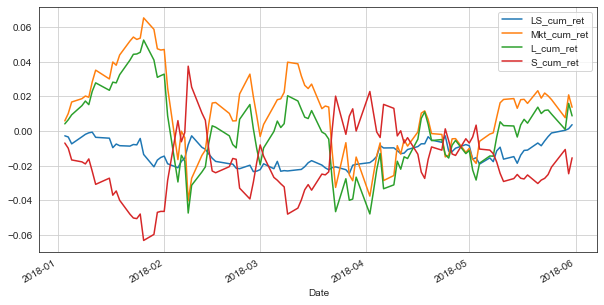

In [0]:
import matplotlib.pyplot as plt

strat_sum.plot(x='Date', y=['LS_cum_ret', 'Mkt_cum_ret', 'L_cum_ret', 'S_cum_ret'], figsize=(10,5), grid=True)


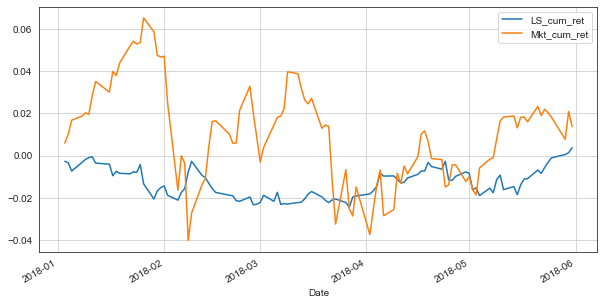

In [0]:
strat_sum.plot(x='Date', y=['LS_cum_ret', 'Mkt_cum_ret'], figsize=(10,5), grid=True)

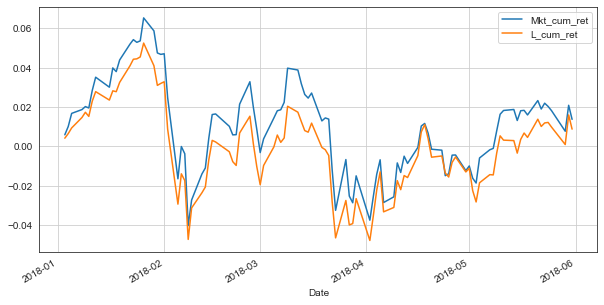

In [0]:
strat_sum.plot(x='Date', y=['Mkt_cum_ret', 'L_cum_ret'], figsize=(10,5), grid=True)

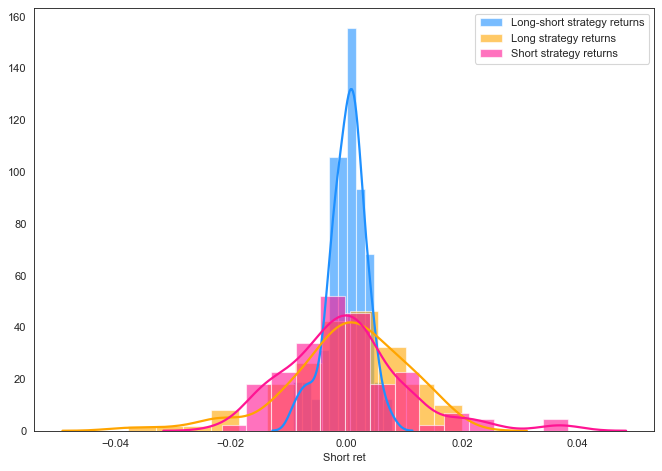

In [0]:
import seaborn as sns
sns.set_style("white")

# Import data
x1 = strat_sum.loc[:, 'LS ret']
x2 = strat_sum.loc[:, 'Long ret']
x3 = strat_sum.loc[:, 'Short ret']

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Long-short strategy returns", **kwargs)
sns.distplot(x2, color="orange", label="Long strategy returns", **kwargs)
sns.distplot(x3, color="deeppink", label="Short strategy returns", **kwargs)
plt.legend();

## Inside industry using industry sentiment index

In [0]:
industrials = ret[ret['GICS Sector'] == 'Materials']
industrials

,Date,High,Low,Open,Close,Volume,Adj Close,Return,Symbol,Security,GICS Sector,Industry Sentiment vader,Industry Sentiment bert,Company Sentiment,LOGCAP
1248,2018-01-02,165.539993,163.800003,164.880005,165.509995,1051900.0,157.596207,NaN,APD,Air Products & Chemicals Inc,Materials,0.986500,0.000000,0.0,18.975140
1249,2018-01-03,166.619995,165.000000,165.559998,166.410004,798200.0,158.453171,0.005438,APD,Air Products & Chemicals Inc,Materials,0.735386,0.000000,0.0,18.704569
1250,2018-01-04,167.850006,166.679993,167.309998,167.050003,932400.0,159.062561,0.003846,APD,Air Products & Chemicals Inc,Materials,0.392225,-0.428571,0.0,18.863810
1251,2018-01-05,168.970001,167.089996,167.960007,168.449997,742200.0,160.395615,0.008381,APD,Air Products & Chemicals Inc,Materials,0.953267,-1.000000,0.0,18.644013
1252,2018-01-08,168.809998,167.119995,168.259995,168.630005,802100.0,160.567017,0.001069,APD,Air Products & Chemicals Inc,Materials,0.810120,1.000000,0.0,18.722696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50066,2018-05-24,60.970001,60.000000,60.560001,60.660000,1452800.0,56.154697,-0.001810,WRK,WestRock,Materials,0.459400,-0.333333,-1.0,18.294288
50067,2018-05-25,60.580002,59.619999,60.439999,59.959999,1779300.0,55.506683,-0.011540,WRK,WestRock,Materials,0.000000,-0.800000,0.0,18.485408
50068,2018-05-29,60.080002,58.860001,59.509998,59.029999,2301700.0,54.645760,-0.015510,WRK,WestRock,Materials,0.992688,-0.333333,0.0,18.727204
50069,2018-05-30,60.139999,59.430000,59.560001,59.759998,1477400.0,55.321541,0.012367,WRK,WestRock,Materials,0.912133,0.500000,0.0,18.296131


In [0]:
groups = industrials.groupby(['Date'])

m = pd.DataFrame()
portfolios = {}
ret_mean = {}
cap_mean = {}
ret_mean_next = {}
cap_mean_next = {}

pnum = 10
print('No portfolios!')
for idx in range(pnum) :
    portfolios[idx] = pd.DataFrame()

for group_name, group in groups :
    g = group.dropna().sort_values(['Company Sentiment'])
    l = int(g.shape[0]/pnum)
    for idx in range(pnum) :
        portfolios[idx] = portfolios[idx].append(g.iloc[idx*l : (idx+1)*l - 1])

No portfolios!


In [0]:
for idx in range(pnum) :
    ret_mean[idx] = portfolios[idx].groupby('Date')['Return'].mean()

In [0]:
import statsmodels.api as sm
dates = np.sort(ret.dropna().Date.unique())
cpm = {}
mkt = ff_fact['Mkt-RF'][1:]
X = sm.add_constant(mkt)
for idx in range(pnum) :
    ret_mean_next[idx] = np.empty(len(dates))
    cap_mean_next[idx] = np.empty(len(dates))
    for i in range(len(dates) - 1):
        date = dates[i]
        ndate = dates[i+1]
        permno = portfolios[idx].Symbol[portfolios[idx].Date == date]
        p = industrials[industrials.Date == ndate]
        p = p[p.Symbol.isin(permno)]
        ret_mean_next[idx][i] = p.Return.mean() - ff_fact.iloc[i, 4]
        cap_mean_next[idx][i] = p.LOGCAP.mean()
    cpm[idx] = sm.OLS(ret_mean_next[idx], X).fit()

In [0]:
np.set_printoptions(precision=4)
print('\tRET\talpha\tbeta')
for idx in range(pnum) :
    print("{:d}\t{:.4f}\t{:.4f}\t{:.4f}".format(idx,
        ret_mean_next[idx].mean(), 
        cpm[idx].params[0], cpm[idx].params[1]))

	RET	alpha	beta
0	-0.0507	-0.0506	-0.7756
1	-0.0497	-0.0496	-0.5854
2	-0.0498	-0.0497	-0.5604
3	-0.0503	-0.0502	-0.6770
4	-0.0532	-0.0530	-0.8261
5	-0.0503	-0.0502	-0.6470
6	-0.0496	-0.0494	-0.6449
7	-0.0505	-0.0504	-0.4869
8	-0.0499	-0.0497	-0.7058
9	-0.0488	-0.0487	-0.6721


In [0]:
long_short_ret = portfolios[9].groupby('Date')['Return'].mean() - portfolios[0].groupby('Date')['Return'].mean()
long_ret = portfolios[9].groupby('Date')['Return'].mean()
short_ret = -portfolios[0].groupby('Date')['Return'].mean()
long_short = pd.DataFrame(long_short_ret)
strat_sum = pd.DataFrame()
strat_sum['LS ret'] = long_short_ret
strat_sum['Long ret'] = long_ret
strat_sum['Short ret'] = short_ret
strat_sum['MktRF'] = np.array(mkt)
strat_sum['Date'] = np.sort(ret.dropna().Date.unique())
strat_sum['Mkt_cum_ret'] = (1+strat_sum['MktRF']).cumprod() - 1
strat_sum['LS_cum_ret'] = (1+strat_sum['LS ret']).cumprod() - 1
strat_sum['L_cum_ret'] = (1+strat_sum['Long ret']).cumprod() - 1
strat_sum['S_cum_ret'] = (1+strat_sum['Short ret']).cumprod() - 1
print(strat_sum)

              LS ret  Long ret  Short ret   MktRF       Date  Mkt_cum_ret  \
Date                                                                        
2018-01-03 -0.005206  0.000232  -0.005438  0.0059 2018-01-03     0.005900   
2018-01-04 -0.005911  0.019165  -0.025076  0.0042 2018-01-04     0.010125   
2018-01-05  0.003611  0.013029  -0.009418  0.0066 2018-01-05     0.016792   
2018-01-08 -0.000291  0.000777  -0.001069  0.0019 2018-01-08     0.018724   
2018-01-09  0.007708  0.002395   0.005313  0.0015 2018-01-09     0.020252   
...              ...       ...        ...     ...        ...          ...   
2018-05-24  0.002074  0.000264   0.001810 -0.0016 2018-05-24     0.020336   
2018-05-25 -0.007311 -0.009415   0.002105 -0.0021 2018-05-25     0.018193   
2018-05-29  0.022292 -0.002884   0.025176 -0.0103 2018-05-29     0.007706   
2018-05-30 -0.000915  0.006687  -0.007602  0.0131 2018-05-30     0.020907   
2018-05-31  0.005826 -0.009629   0.015455 -0.0070 2018-05-31     0.013761   

In [0]:
strategy = pd.DataFrame(columns = ['Name', 'Mean', 'Std', 'SR'])
l_strat = pd.DataFrame(columns = ['Name', 'Mean', 'Std', 'SR'])
s_strat = pd.DataFrame(columns = ['Name', 'Mean', 'Std', 'SR'])

def my(df, name, ret, sent) :
    m = np.mean(ret)
    s = np.std(ret)
    df = df.append({'Name' : name, 'Mean' : m, 'Std' : s, 'SR' : m/s}, ignore_index=True)
    
    median = sent.rolling(5).median()
    msk = sent - median > 0
    msk = msk.shift()[5:]
    ret = ret[5:]

    r_pos = ret[msk]
    m = np.mean(r_pos)
    s = np.std(r_pos)
    df = df.append({'Name' : name + ' HS', 'Mean' : m, 'Std' : s, 'SR' : m/s}, ignore_index=True)

    r_neg = ret[msk == False]
    m = np.mean(r_neg)
    s = np.std(r_neg)
    df = df.append({'Name' : name + ' LS', 'Mean' : m, 'Std' : s, 'SR' : m/s}, ignore_index=True)

    return df, r_pos, r_neg

In [0]:
#sent = sent_ind_bert.loc[list(ret['Date'].unique()[1:]), 'Industrials']
sent = sent_ind_bert.loc[:, 'Materials']
#print(sent_ind_bert.index)
sent
strat_sum['LS ret']

Date
2018-01-03   -0.005206
2018-01-04   -0.005911
2018-01-05    0.003611
2018-01-08   -0.000291
2018-01-09    0.007708
                ...   
2018-05-24    0.002074
2018-05-25   -0.007311
2018-05-29    0.022292
2018-05-30   -0.000915
2018-05-31    0.005826
Name: LS ret, Length: 103, dtype: float64

In [0]:
strat_sum.index = strat_sum.index.astype(date)
sent.index = sent.index.astype(date)
strategy = my(strategy, 'Comp Sentiment Index', strat_sum['LS ret'], sent)

In [0]:
print(strategy[0])

                      Name      Mean       Std        SR
0     Comp Sentiment Index  0.002599  0.018074  0.143823
1  Comp Sentiment Index HS  0.002985  0.018493  0.161404
2  Comp Sentiment Index LS  0.002611  0.018476  0.141314


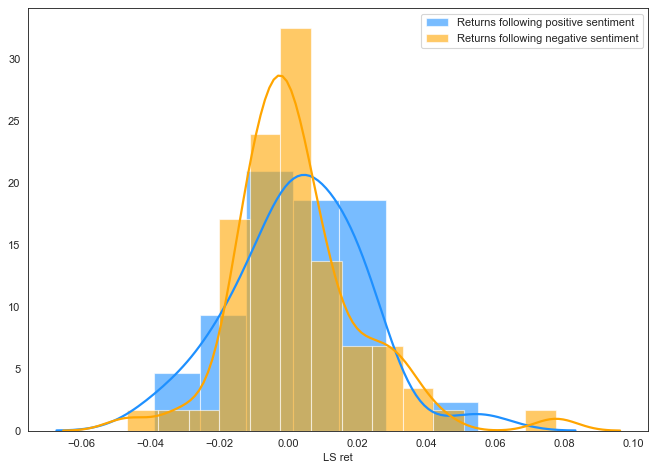

In [0]:
sns.set_style("white")

# Import data
x1 = strategy[1]
x2 = strategy[2]

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Returns following positive sentiment", **kwargs)
sns.distplot(x2, color="orange", label="Returns following negative sentiment", **kwargs)
plt.legend();